In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy import stats

# Defining Reusable Functions

In [11]:
from pandas.api.types import is_numeric_dtype, is_categorical_dtype
# from scipy.stats import f_oneway, chi2_contingency, pearsonr

def calculate_correlation(input_var, output_var):
    """Calculate correlation based on variable types."""
    # Determine variable types
    input_is_numeric = is_numeric_dtype(input_var)
    output_is_numeric = is_numeric_dtype(output_var)
    input_is_categorical = is_categorical_dtype(input_var) or input_var.dtype == 'object'
    output_is_categorical = is_categorical_dtype(output_var) or output_var.dtype == 'object'

    # Case 1: Both input and output are numerical (Pearson's correlation)
    if input_is_numeric and output_is_numeric:
        corr, p_value = stats.pearsonr(input_var, output_var)
        return {"method": "Pearson", "correlation": corr, "p_value": p_value}

    # Case 2: Input is categorical and output is numerical (F-statistic, ANOVA)
    elif input_is_categorical and output_is_numeric:
        groups = [output_var[input_var == level] for level in input_var.unique()]
        f_stat, p_value = stats.f_oneway(*groups)
        return {"method": "F-statistic (ANOVA)", "statistic": f_stat, "p_value": p_value}

    # Case 3: Input is numerical and output is categorical (F-statistic, ANOVA)
    elif input_is_numeric and output_is_categorical:
        groups = [input_var[output_var == level] for level in output_var.unique()]
        f_stat, p_value = stats.f_oneway(*groups)
        return {"method": "F-statistic (ANOVA)", "statistic": f_stat, "p_value": p_value}

    # Case 4: Both input and output are categorical (Chi-square test)
    elif input_is_categorical and output_is_categorical:
        contingency_table = pd.crosstab(input_var, output_var)
        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
        return {"method": "Chi-square", "statistic": chi2, "p_value": p_value}

    # If none of the above cases apply
    else:
        raise ValueError("Unsupported combination of variable types.")


In [ ]:
def mixed_correlation_heatmap(df: pd.DataFrame, x=8, y=6, dpi=100):
    """
    Generate a correlation heatmap for a DataFrame with mixed numerical and categorical data types.
    
    Parameters:
    - df: pd.DataFrame, the input DataFrame
    - x: int, width of the figure
    - y: int, height of the figure
    - dpi: int, resolution of the figure
    
    Returns:
    - Displays a heatmap of pairwise correlation statistics.
    """
    def calculate_correlation(col1, col2):
        # Check types
        col1_is_numeric = is_numeric_dtype(col1)
        col2_is_numeric = is_numeric_dtype(col2)
        col1_is_categorical = is_categorical_dtype(col1) or col1.dtype == 'object'
        col2_is_categorical = is_categorical_dtype(col2) or col2.dtype == 'object'

        # Pearson correlation for numerical-numerical
        if col1_is_numeric and col2_is_numeric:
            corr, _ = pearsonr(col1, col2)
            return corr

        # F-statistic for categorical-numerical
        elif col1_is_categorical and col2_is_numeric:
            groups = [col2[col1 == level] for level in col1.unique()]
            f_stat, _ = f_oneway(*groups)
            return f_stat

        elif col1_is_numeric and col2_is_categorical:
            groups = [col1[col2 == level] for level in col2.unique()]
            f_stat, _ = f_oneway(*groups)
            return f_stat

        # Chi-square test for categorical-categorical
        elif col1_is_categorical and col2_is_categorical:
            contingency_table = pd.crosstab(col1, col2)
            chi2, _, _, _ = chi2_contingency(contingency_table)
            return chi2

        # If types are unsupported, return NaN
        return np.nan

    # Calculate the correlation matrix
    cols = df.columns
    corr_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0  # Perfect self-correlation
            else:
                corr_matrix.loc[col1, col2] = calculate_correlation(df[col1], df[col2])

    # Plot the heatmap
    plt.figure(figsize=(x, y), dpi=dpi)
    sns.heatmap(corr_matrix.astype(float), 
                annot=True, 
                fmt='.2f', 
                cmap='RdBu_r', 
                center=0, 
                square=True, 
                cbar_kws={'label': 'Correlation/Statistic'})
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title("Mixed-Type Correlation Heatmap")
    plt.tight_layout()
    plt.show()

    return corr_matrix

# Analysing the first available Parquet File

In [5]:
dirs = [d for d in Path('series_train.parquet').iterdir() if d.is_dir()]

def analyse_parquet(parquet_file: Path) :
  return pd.read_parquet(parquet_file)
  
for dir in dirs:
  row_id = str(dir).split("id=")[1]
  parquet_file = next(dir.glob("*.parquet"))

df = analyse_parquet(parquet_file)
df.head()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'series_train.parquet'

In [ ]:
df.columns

Index(['step', 'X', 'Y', 'Z', 'enmo', 'anglez', 'non-wear_flag', 'light',
       'battery_voltage', 'time_of_day', 'weekday', 'quarter',
       'relative_date_PCIAT'],
      dtype='object')

## Removing Rows where accelerometer hasn't been worn

In [ ]:
rows_before = len(df)

# Apply filter
df = df[df['non-wear_flag'] != 1]

# Count rows after filtering
rows_after = len(df)

# Calculate number of rows removed
rows_removed = rows_before - rows_after
rows_removed

224884

## Analaysis of Accelerometer data wrt Time of day (hours)

In [ ]:
# Convert nanoseconds to hours of day
# First convert to seconds by dividing by 1e9, then get hours by dividing seconds by 3600
df['time_of_day_hours'] = ((df['time_of_day'] / 1e9) % 86400 / 3600).astype(int)
df['time_of_day_hours'].head()

0    12
1    12
2    12
3    12
4    12
Name: time_of_day_hours, dtype: int64

In [ ]:
# Create a single DataFrame with means of all desired columns
avg_df_hours = df.groupby('time_of_day_hours')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()
avg_df_hours.head()

,time_of_day_hours,X,Y,Z,anglez,light,enmo
0,0,0.155875,0.075954,-0.026142,-5.501348,4.860384,0.003676
1,1,-0.220306,0.161074,-0.295415,-22.773060,4.870170,0.004583
2,2,0.051411,-0.129772,-0.407232,-28.732391,5.687574,0.005606
3,3,-0.089633,0.020714,-0.312193,-25.195501,6.009756,0.003391
4,4,-0.108234,0.102704,-0.075998,-8.072747,7.111255,0.003330


In [ ]:
def get_figure(ax, x, y, title, xlabel, ylabel):
    
    ax.plot(x, y, 'b-', linewidth=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Set x-axis ticks for every hour
    ax.set_xticks(range(0, 24))
    ax.tick_params(axis='x', rotation=45)  # Rotate x ticks by 45 degrees
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    return ax    

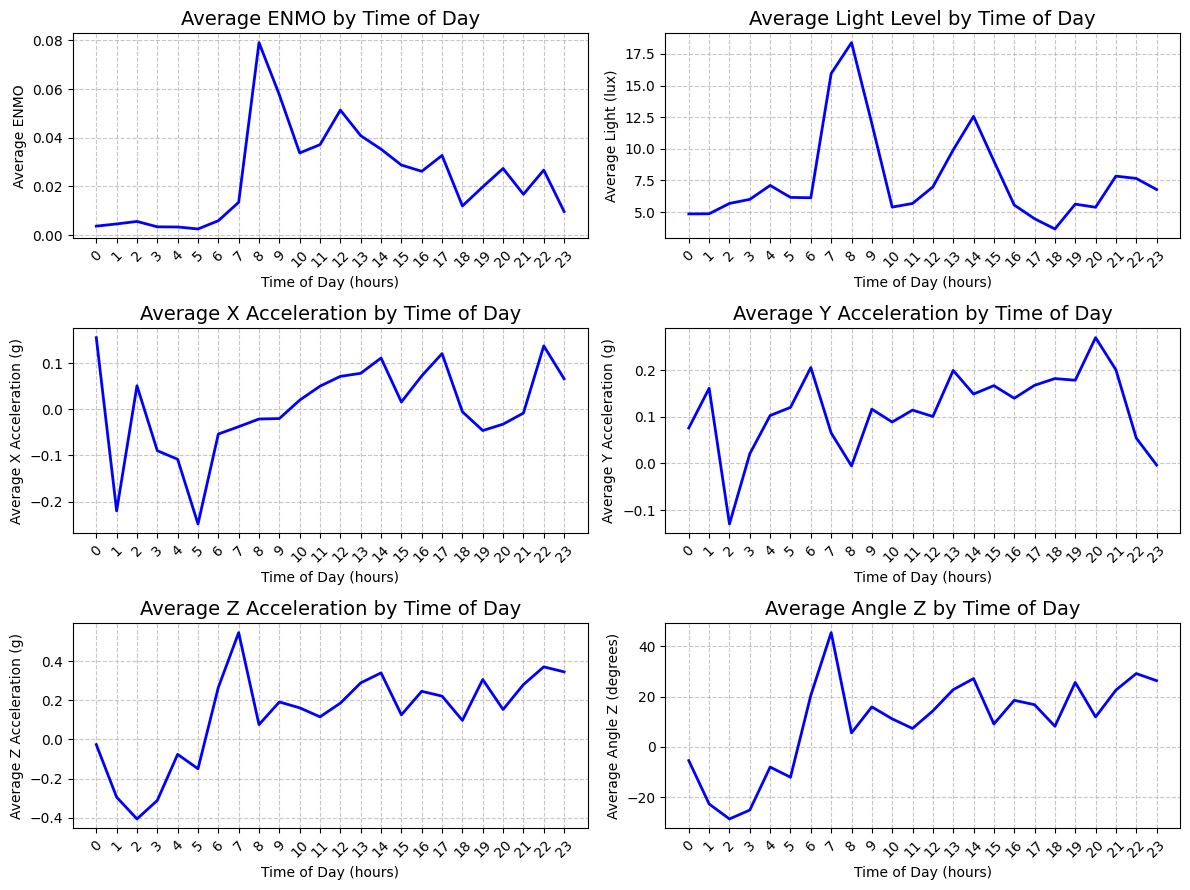

In [ ]:
# Create the plot
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 9))

get_figure(ax1, avg_df_hours['time_of_day_hours'], avg_df_hours['enmo'], 
          'Average ENMO by Time of Day', 
          'Time of Day (hours)', 
          'Average ENMO')

get_figure(ax2, avg_df_hours['time_of_day_hours'], avg_df_hours['light'], 
          'Average Light Level by Time of Day', 
          'Time of Day (hours)', 
          'Average Light (lux)')

get_figure(ax3, avg_df_hours['time_of_day_hours'], avg_df_hours['X'], 
          'Average X Acceleration by Time of Day', 
          'Time of Day (hours)', 
          'Average X Acceleration (g)')

get_figure(ax4, avg_df_hours['time_of_day_hours'], avg_df_hours['Y'], 
          'Average Y Acceleration by Time of Day', 
          'Time of Day (hours)', 
          'Average Y Acceleration (g)')

get_figure(ax5, avg_df_hours['time_of_day_hours'], avg_df_hours['Z'], 
          'Average Z Acceleration by Time of Day', 
          'Time of Day (hours)', 
          'Average Z Acceleration (g)')

get_figure(ax6, avg_df_hours['time_of_day_hours'], avg_df_hours['anglez'], 
          'Average Angle Z by Time of Day', 
          'Time of Day (hours)', 
          'Average Angle Z (degrees)')

plt.tight_layout()
plt.show()

In [ ]:
# First calculate the correlation matrix using pandas
mixed_correlation_heatmap(avg_df_hours.drop('time_of_day_hours', axis=1))

NameError: name 'mixed_correlation_heatmap' is not defined

In [ ]:
# Create a dictionary to store the new columns
flattened_data = {}

# For each variable, create 24 columns
for var in ['X', 'Y', 'Z', 'anglez', 'light']:
    for hour in range(24):
        # Get the value for this hour
        value = avg_df_hours[avg_df_hours['time_of_day_hours'] == hour][var].iloc[0] if not avg_df_hours[avg_df_hours['time_of_day_hours'] == hour].empty else None
        # Create new column name (e.g., 'X_1', 'X_2', etc.)
        col_name = f'{var}_{hour}'
        flattened_data[col_name] = [value]

# Create new dataframe
flat_df = pd.DataFrame(flattened_data)

# Optionally, sort columns to group variables together
flat_df = flat_df.reindex(sorted(flat_df.columns), axis=1)

flat_df

,X_0,X_1,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,...,light_21,light_22,light_23,light_3,light_4,light_5,light_6,light_7,light_8,light_9
0,0.155875,-0.220306,0.020144,0.050523,0.071821,0.078394,0.111609,0.016089,0.072837,0.121217,...,7.84535,7.662183,6.786202,6.009756,7.111255,6.164332,6.136124,15.945152,18.387943,11.996333


## Now evaluating the average data per weekday

In [ ]:
def get_continuous_sequence(numbers):
    # Convert pandas Series to list if needed
    if hasattr(numbers, 'tolist'):
        numbers = numbers.tolist()
    
    # Now check for empty list
    if not numbers or len(numbers) == 0:
        return []
        
    continuous = [numbers[0]]  # Initialize with first number
    for i in range(1, len(numbers)):
        current = numbers[i]
        prev = numbers[i-1]
        
        # If current number is less than previous, it means we've started a new week
        if current < prev:
            # Add 7 to make it continue from the previous week
            continuous.append(continuous[-1] + (current - prev + 7))
        # If current equals previous, keep the same continuous number
        elif current == prev:
            continuous.append(continuous[-1])
        # If current is greater than previous, add the difference
        else:
            continuous.append(continuous[-1] + (current - prev))
            
    return continuous

In [ ]:
df['continuous_weekdays'] = get_continuous_sequence(df['weekday']) 
df['continuous_weekdays'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [ ]:
# Create a single DataFrame with means of all desired columns
avg_df_weekday = df.groupby('continuous_weekdays')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()
avg_df_weekday.head()

,continuous_weekdays,X,Y,Z,anglez,light,enmo
0,1,-0.297996,0.213239,-0.192772,-16.366659,11.840536,0.045037
1,2,0.234503,0.176854,0.029267,2.695048,10.292953,0.038168
2,3,-0.263681,0.231898,0.030455,3.274946,8.682956,0.027509
3,4,0.176673,0.031153,0.121483,8.291156,9.622711,0.026469
4,5,0.510846,-0.046606,-0.159633,-11.145076,16.207735,0.080757


In [ ]:
def get_figure_weekday(ax, x, y, title, xlabel, ylabel):
    
    ax.plot(x, y, 'b-', linewidth=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Set x-axis ticks for every hour
    # Set x-axis ticks
    # ax.set_xticks(range(len(x)))  # This sets a tick for each x value
    # ax.tick_params(axis='x', rotation=45)  # Rotate x ticks by 45 degrees
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    return ax    

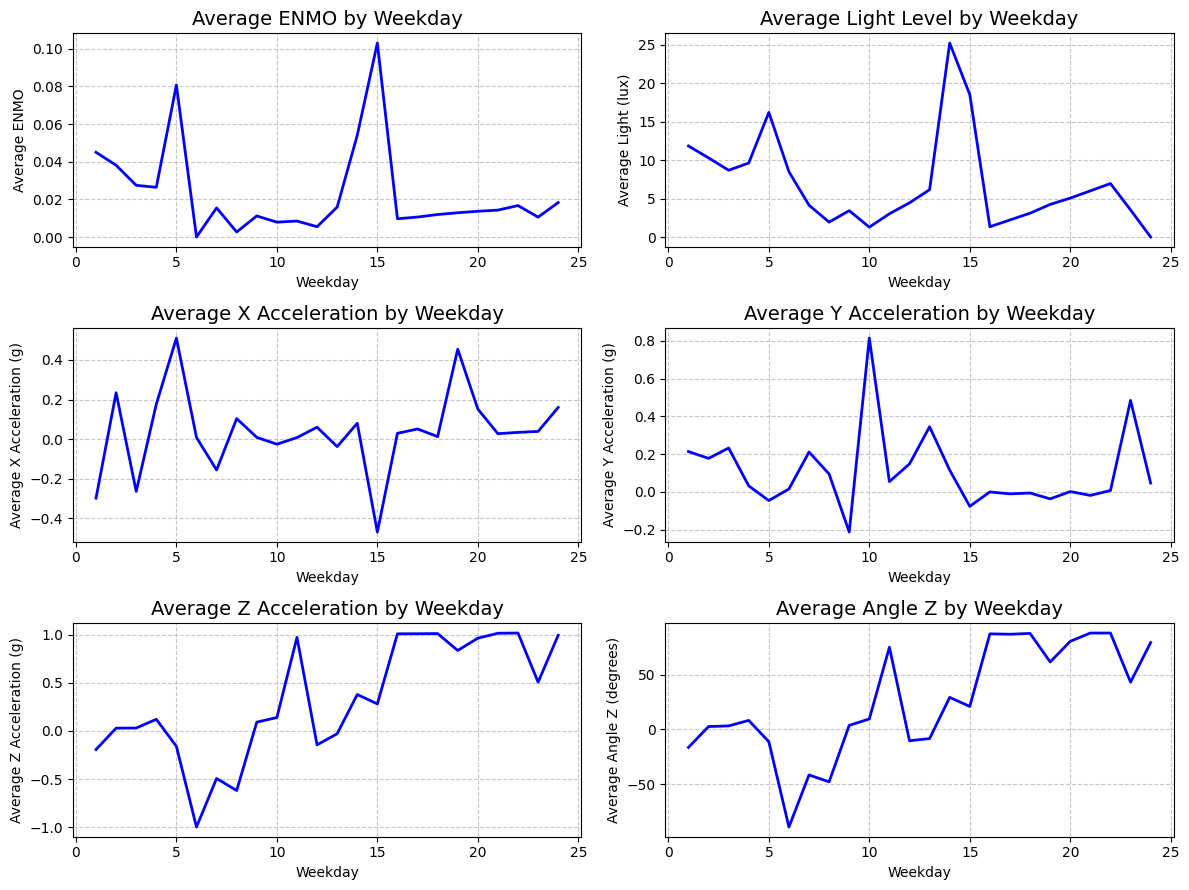

In [ ]:
# Create the plot
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 9))

get_figure_weekday(ax1, avg_df_weekday['continuous_weekdays'], avg_df_weekday['enmo'], 
          'Average ENMO by Weekday', 
          'Weekday', 
          'Average ENMO')

get_figure_weekday(ax2, avg_df_weekday['continuous_weekdays'], avg_df_weekday['light'], 
          'Average Light Level by Weekday', 
          'Weekday', 
          'Average Light (lux)')

get_figure_weekday(ax3, avg_df_weekday['continuous_weekdays'], avg_df_weekday['X'], 
          'Average X Acceleration by Weekday', 
          'Weekday', 
          'Average X Acceleration (g)')

get_figure_weekday(ax4, avg_df_weekday['continuous_weekdays'], avg_df_weekday['Y'], 
          'Average Y Acceleration by Weekday', 
          'Weekday',  
          'Average Y Acceleration (g)')

get_figure_weekday(ax5, avg_df_weekday['continuous_weekdays'], avg_df_weekday['Z'], 
          'Average Z Acceleration by Weekday', 
          'Weekday', 
          'Average Z Acceleration (g)')

get_figure_weekday(ax6, avg_df_weekday['continuous_weekdays'], avg_df_weekday['anglez'], 
          'Average Angle Z by Weekday', 
          'Weekday', 
          'Average Angle Z (degrees)')

plt.tight_layout()
plt.show()

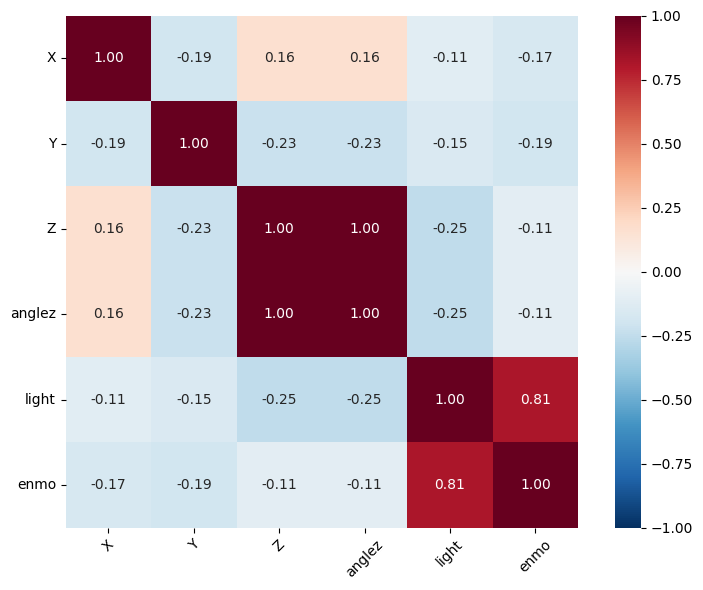

In [ ]:
# First calculate the correlation matrix using pandas
correlation_heatmap(avg_df_weekday.drop('continuous_weekdays', axis=1))

## Conclusions from Analysis

1. Anglez and Z are heavily correlated.
2. X, Y and Z may not be quite as useful as Enmo. Initially discarding the data. If we do not get satisfactory results, we shall consider using X, Y and Z again.
3. Light and Enmo are correlated, but since we're using just one child's Accelerometer data, it might not be the same throughout. Hence, we should ideally keep them both in.

## Flattening Hourly Data

In [ ]:
# Create a dictionary to store the new columns
flattened_data = {}

# For each variable, create 24 columns
for var in ['enmo', 'light']:
    for hour in range(24):
        # Get the value for this hour
        value = avg_df_hours[avg_df_hours['time_of_day_hours'] == hour][var].iloc[0] if not avg_df_hours[avg_df_hours['time_of_day_hours'] == hour].empty else None
        # Create new column name (e.g., 'X_1', 'X_2', etc.)
        col_name = f'{var}_h{hour}'
        flattened_data[col_name] = [value]

# Create new dataframe
hourly_flat_df = pd.DataFrame(flattened_data)

# Optionally, sort columns to group variables together
# hourly_flat_df = hourly_flat_df.reindex(sorted(hourly_flat_df.columns), axis=1)

hourly_flat_df

,enmo_h0,enmo_h1,enmo_h2,enmo_h3,enmo_h4,enmo_h5,enmo_h6,enmo_h7,enmo_h8,enmo_h9,...,light_h14,light_h15,light_h16,light_h17,light_h18,light_h19,light_h20,light_h21,light_h22,light_h23
0,0.003676,0.004583,0.005606,0.003391,0.00333,0.002519,0.005899,0.013478,0.079089,0.057646,...,12.564425,9.036289,5.561802,4.479136,3.671882,5.632383,5.384964,7.84535,7.662183,6.786202


## Flattening Weekday Data

In [ ]:
# Create a dictionary to store the new columns
flattened_data = {}

# For each variable, create columns for each unique weekday
for var in ['enmo', 'light']:
    # Get the unique weekdays in sorted order
    unique_weekdays = sorted(avg_df_weekday['continuous_weekdays'].unique())
    
    for weekday in unique_weekdays:
        # Get the value for this weekday
        value = avg_df_weekday[avg_df_weekday['continuous_weekdays'] == weekday][var].iloc[0] if not avg_df_weekday[avg_df_weekday['continuous_weekdays'] == weekday].empty else None
        # Create new column name (e.g., 'enmo_1', 'enmo_2', etc.)
        col_name = f'{var}_w{weekday}'
        flattened_data[col_name] = [value]

# Create new dataframe
weekday_flat_df = pd.DataFrame(flattened_data)
# Optionally, sort columns to group variables together
# weekday_flat_df = weekday_flat_df.reindex(sorted(weekday_flat_df.columns), axis=1)
weekday_flat_df

,enmo_w1,enmo_w2,enmo_w3,enmo_w4,enmo_w5,enmo_w6,enmo_w7,enmo_w8,enmo_w9,enmo_w10,...,light_w15,light_w16,light_w17,light_w18,light_w19,light_w20,light_w21,light_w22,light_w23,light_w24
0,0.045037,0.038168,0.027509,0.026469,0.080757,0.00007,0.015531,0.002758,0.011258,0.007962,...,18.520447,1.337878,2.21862,3.100655,4.238798,5.062794,6.006053,6.953397,3.530664,0.0


## Creating a combined dataframe

In [ ]:
combined_df = pd.concat([hourly_flat_df, weekday_flat_df], axis=1)
combined_df.head()

,enmo_h0,enmo_h1,enmo_h2,enmo_h3,enmo_h4,enmo_h5,enmo_h6,enmo_h7,enmo_h8,enmo_h9,...,light_w15,light_w16,light_w17,light_w18,light_w19,light_w20,light_w21,light_w22,light_w23,light_w24
0,0.003676,0.004583,0.005606,0.003391,0.00333,0.002519,0.005899,0.013478,0.079089,0.057646,...,18.520447,1.337878,2.21862,3.100655,4.238798,5.062794,6.006053,6.953397,3.530664,0.0


# Function for appending averaged Parquet File into Main CSV File

In [ ]:
def extract_id(path):
    return path.split('id=')[1].split('\\')[0]

def get_combined_avg(parquet_file: Path, n: int) :

    if n%50 == 0: print(f"{n} files processed")

    row_id = extract_id(str(parquet_file))
    # print('Analysing data for id: '+row_id)
    
    df = pd.read_parquet(parquet_file)
    
    # Apply filter
    df = df[df['non-wear_flag'] != 1]

    # Convert nanoseconds to hours of day
    # First convert to seconds by dividing by 1e9, then get hours by dividing seconds by 3600
    df['time_of_day_hours'] = ((df['time_of_day'] / 1e9) % 86400 / 3600).astype(int)

    # Create a single DataFrame with means of all desired columns
    avg_df_hours = df.groupby('time_of_day_hours')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()

    # Create a dictionary to store the new columns
    flattened_data = {}
    
    # For each variable, create 24 columns
    for var in ['enmo', 'light']:
        for hour in range(24):
            # Get the value for this hour
            value = avg_df_hours[avg_df_hours['time_of_day_hours'] == hour][var].iloc[0] if not avg_df_hours[avg_df_hours['time_of_day_hours'] == hour].empty else None
            # Create new column name (e.g., 'X_1', 'X_2', etc.)
            col_name = f'{var}_h{hour}'
            flattened_data[col_name] = [value]
    
    # Create new dataframe
    hourly_flat_df = pd.DataFrame(flattened_data)

    df['continuous_weekdays'] = get_continuous_sequence(df['weekday']) 
    
    # Create a single DataFrame with means of all desired columns
    avg_df_weekday = df.groupby('continuous_weekdays')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()

    # Create a dictionary to store the new columns
    flattened_data = {}
    
    # For each variable, create columns for each unique weekday
    for var in ['enmo', 'light']:
        # Get the unique weekdays in sorted order
        unique_weekdays = sorted(avg_df_weekday['continuous_weekdays'].unique())
        
        for weekday in unique_weekdays:
            # Get the value for this weekday
            value = avg_df_weekday[avg_df_weekday['continuous_weekdays'] == weekday][var].iloc[0] if not avg_df_weekday[avg_df_weekday['continuous_weekdays'] == weekday].empty else None
            # Create new column name (e.g., 'enmo_1', 'enmo_2', etc.)
            col_name = f'{var}_w{weekday}'
            flattened_data[col_name] = [value]
    
    # Create new dataframe
    weekday_flat_df = pd.DataFrame(flattened_data)

    combined_df = pd.concat([hourly_flat_df, weekday_flat_df], axis=1)
    combined_df['id'] = row_id
    
    return combined_df

In [ ]:
dirs = [d for d in Path('series_train.parquet').iterdir() if d.is_dir()]
print(f'Total numbers of parquet_files to process: {len(dirs)}')
df_list = []  # Create empty list to store DataFrames
n = 0

for dir in dirs:
    row_id = str(dir).split("id=")[1]
    parquet_file = next(dir.glob("*.parquet"))
    temp_df = get_combined_avg(parquet_file, n)  # Gets single row DataFrame
    df_list.append(temp_df)
    n+=1

# Combine all DataFrames at once
final_df = pd.concat(df_list, ignore_index=True)
final_df = final_df.reindex(sorted(final_df.columns, key=str.lower), axis=1)
final_df.head()

Total numbers of parquet_files to process: 996
0 files processed
50 files processed
100 files processed
150 files processed
200 files processed
250 files processed
300 files processed
350 files processed
400 files processed
450 files processed
500 files processed
550 files processed
600 files processed
650 files processed
700 files processed
750 files processed
800 files processed
850 files processed
900 files processed
950 files processed


C:\Users\User\AppData\Local\Temp\ipykernel_133068\3335636270.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(df_list, ignore_index=True)


,enmo_h0,enmo_h1,enmo_h10,enmo_h11,enmo_h12,enmo_h13,enmo_h14,enmo_h15,enmo_h16,enmo_h17,...,light_w9,light_w90,light_w91,light_w92,light_w93,light_w94,light_w95,light_w96,light_w97,light_w99
0,0.020952,0.033222,0.046533,0.043808,0.030952,0.065813,0.045689,0.031533,0.058526,0.053016,...,13.224856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.002808,0.008027,0.021365,0.023271,0.038819,0.019645,0.030716,0.026229,0.018902,0.023248,...,24.121109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.004010,0.003738,0.049295,0.039044,0.149919,0.073839,0.054163,0.074922,0.045967,0.030919,...,33.663876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.004876,0.004869,0.065006,0.047939,0.047176,0.059867,0.052670,0.047561,0.064359,0.050110,...,13.530785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.005384,0.004706,0.061734,0.050658,0.112435,0.126275,0.078224,0.228003,0.173780,0.066350,...,48.232033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
final_df.to_csv('avg_parquet.csv')

# Analysing Main CSV File

In [4]:
df = pd.read_csv('train.csv')

In [5]:
# df = df.drop(['Basic_Demos-Enroll_Season',
# 'CGAS-Season',
# 'Physical-Season',
# 'Physical-Waist_Circumference',
# 'Physical-Height',
# 'Physical-Weight',
# 'Fitness_Endurance-Season',
# 'Fitness_Endurance-Max_Stage',
# 'Fitness_Endurance-Time_Mins',	
# 'Fitness_Endurance-Time_Sec',
# 'FGC-Season',
# 'FGC-FGC_CU',
# 'FGC-FGC_CU_Zone',	
# 'FGC-FGC_GSND',	
# 'FGC-FGC_GSND_Zone',	
# 'FGC-FGC_GSD',	
# 'FGC-FGC_GSD_Zone',	
# 'FGC-FGC_PU',
# 'FGC-FGC_SRL',
# 'FGC-FGC_SRR',
# 'FGC-FGC_TL',
# 'BIA-Season',
# 'BIA-BIA_BMC',
# 'BIA-BIA_BMI',
# 'BIA-BIA_BMR',
# 'BIA-BIA_ECW',
# 'BIA-BIA_FFM',
# 'BIA-BIA_FFMI',
# 'BIA-BIA_FMI',
# 'PAQ_A-Season',	
# 'PAQ_A-PAQ_A_Total',
# 'PAQ_C-Season',	
# 'PAQ_C-PAQ_C_Total',	
# 'PCIAT-Season',
# 'SDS-Season',
# 'PreInt_EduHx-Season',
# 'BIA-BIA_ICW',
# 'BIA-BIA_LDM',
# 'BIA-BIA_LST',
# 'BIA-BIA_SMM',
# 'SDS-SDS_Total_Raw'], axis=1)

# short_df = df.drop(['PCIAT-PCIAT_01',
# 'PCIAT-PCIAT_02',
# 'PCIAT-PCIAT_03',
# 'PCIAT-PCIAT_04',
# 'PCIAT-PCIAT_05',
# 'PCIAT-PCIAT_06',
# 'PCIAT-PCIAT_07',
# 'PCIAT-PCIAT_08',
# 'PCIAT-PCIAT_09',
# 'PCIAT-PCIAT_10',
# 'PCIAT-PCIAT_11',
# 'PCIAT-PCIAT_12',
# 'PCIAT-PCIAT_13',
# 'PCIAT-PCIAT_14',
# 'PCIAT-PCIAT_15',
# 'PCIAT-PCIAT_16',
# 'PCIAT-PCIAT_17',
# 'PCIAT-PCIAT_18',
# 'PCIAT-PCIAT_19',
# 'PCIAT-PCIAT_20'], axis=1)

# short_df.describe()

In [6]:
df.columns.value_counts()

id                  1
PCIAT-PCIAT_07      1
PCIAT-PCIAT_05      1
PCIAT-PCIAT_04      1
PCIAT-PCIAT_03      1
                   ..
FGC-FGC_PU_Zone     1
FGC-FGC_PU          1
FGC-FGC_GSD_Zone    1
FGC-FGC_GSD         1
sii                 1
Name: count, Length: 82, dtype: int64

In [7]:
threshold = 0.8  # 80% threshold
df = df.loc[:, df.isnull().mean() <= threshold]

In [8]:
df.columns.value_counts()

id                  1
PCIAT-Season        1
PCIAT-PCIAT_07      1
PCIAT-PCIAT_06      1
PCIAT-PCIAT_05      1
                   ..
FGC-FGC_SRL_Zone    1
FGC-FGC_SRL         1
FGC-FGC_PU_Zone     1
FGC-FGC_PU          1
sii                 1
Name: count, Length: 77, dtype: int64

In [ ]:
print(df.isin([np.inf, -np.inf]).sum())

id                                        0
Basic_Demos-Enroll_Season                 0
Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-Season                               0
                                         ..
SDS-SDS_Total_Raw                         0
SDS-SDS_Total_T                           0
PreInt_EduHx-Season                       0
PreInt_EduHx-computerinternet_hoursday    0
sii                                       0
Length: 77, dtype: int64


In [13]:
mixed_correlation_heatmap(df.drop('id', axis=1), 26, 26, 420)

C:\Users\sudha\AppData\Local\Temp\ipykernel_31500\979794761.py:25: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  col1_is_categorical = is_categorical_dtype(col1) or col1.dtype == 'object'
C:\Users\sudha\AppData\Local\Temp\ipykernel_31500\979794761.py:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  col2_is_categorical = is_categorical_dtype(col2) or col2.dtype == 'object'
C:\Users\sudha\AppData\Local\Temp\ipykernel_31500\979794761.py:25: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  col1_is_categorical = is_categorical_dtype(col1) or col1.dtype == 'object'
C:\Users\sudha\AppData\Local\Temp\ipykernel_31500\979794761.py:26: DeprecationWarning: is_categorical_dtype is deprecated and w

ValueError: array must not contain infs or NaNs

# Initial Visualizations

<Axes: xlabel='Basic_Demos-Age', ylabel='count'>

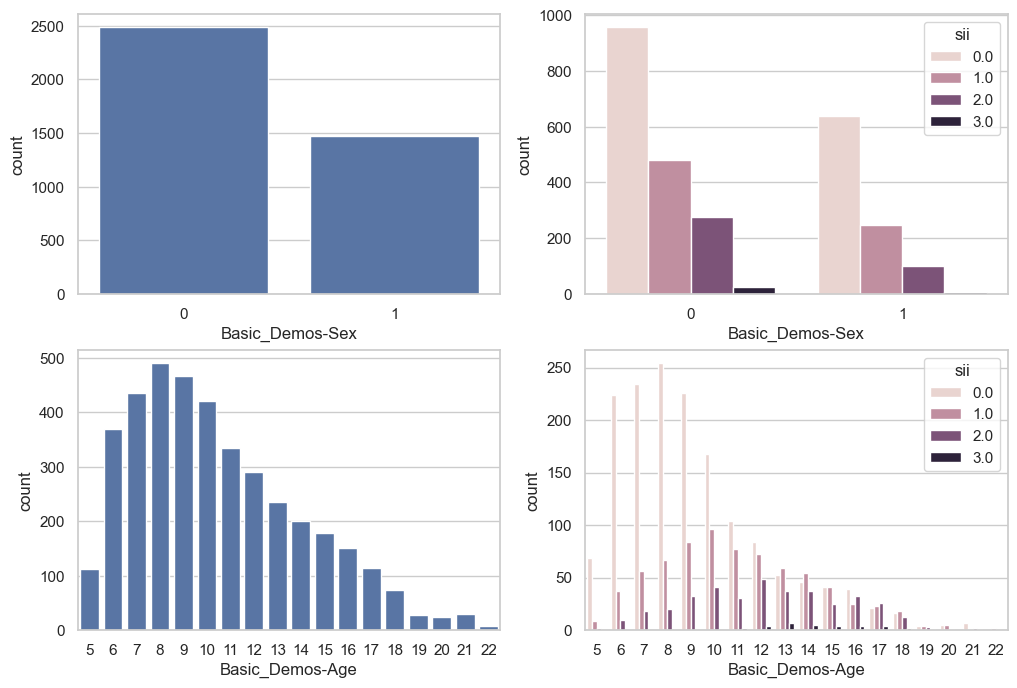

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

sns.countplot(x = 'Basic_Demos-Sex', data = df, ax=ax1)
sns.countplot(x ='Basic_Demos-Sex', hue = "sii", data = df, ax=ax2)
sns.countplot(x = 'Basic_Demos-Age', data = df, ax=ax3)
sns.countplot(x ='Basic_Demos-Age', hue = "sii", data = df, ax=ax4)

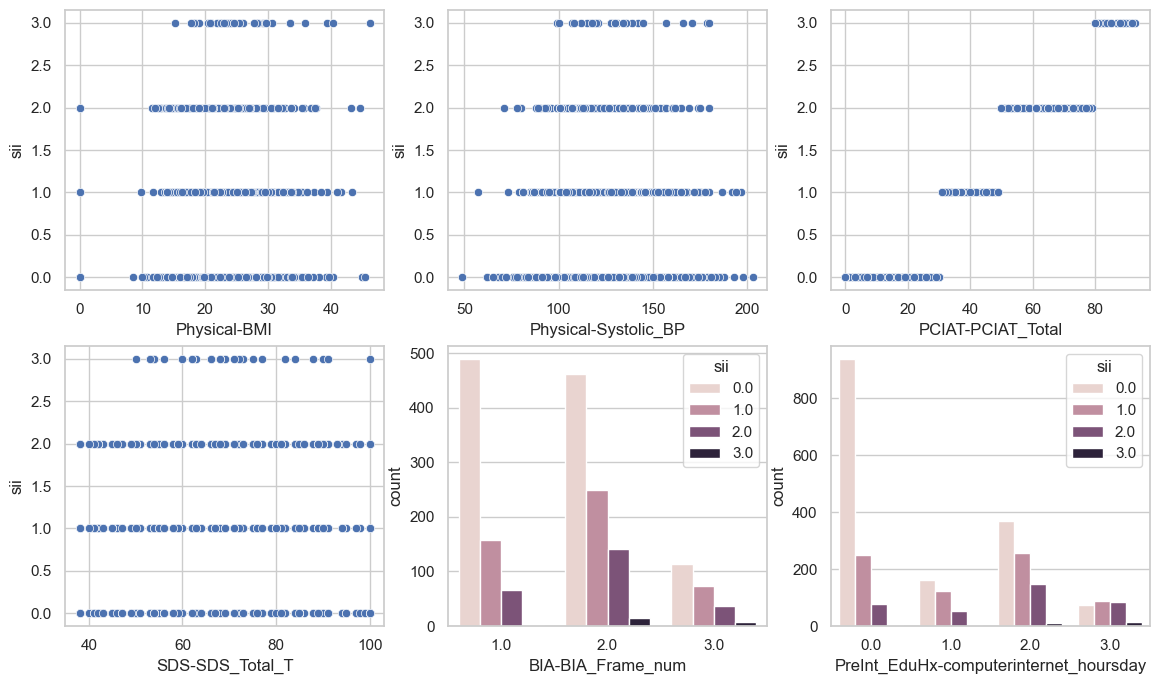

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14,8))

sns.set(style='whitegrid')

sns.scatterplot(x=df["Physical-BMI"], y=df["sii"], data=df, ax=ax1)
sns.scatterplot(x=df["Physical-Systolic_BP"], y=df["sii"], data=df, ax=ax2)
sns.scatterplot(x=df["PCIAT-PCIAT_Total"], y=df["sii"], data=df, ax=ax3)
sns.scatterplot(x=df["SDS-SDS_Total_T"], y=df["sii"], data=df, ax=ax4)
sns.countplot(x ='BIA-BIA_Frame_num', hue = "sii", data = df, ax=ax5)
sns.countplot(x ='PreInt_EduHx-computerinternet_hoursday', hue = "sii", data = df, ax=ax6)

plt.show()

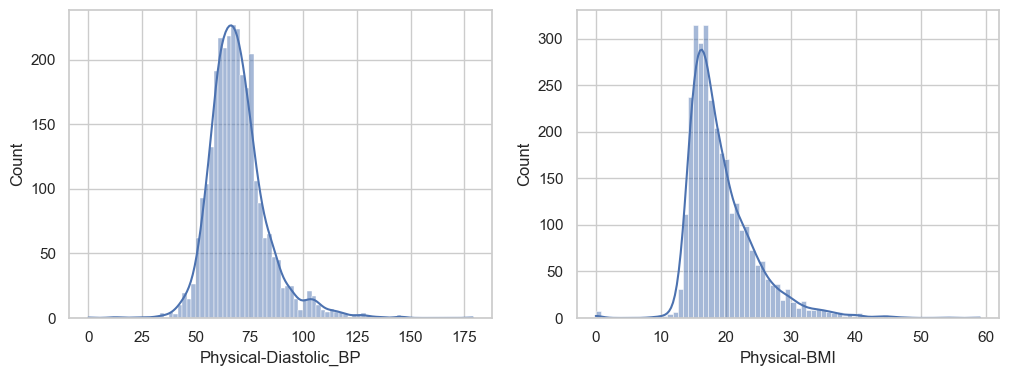

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# ax1.scatter(df['Physical-Diastolic_BP'], df['Physical-Systolic_BP'])
sns.histplot(data=df, x='Physical-Diastolic_BP', kde=True, ax=ax1)
sns.histplot(data=df, x='Physical-BMI', kde=True, ax=ax2)
plt.show()

# Data Cleaning

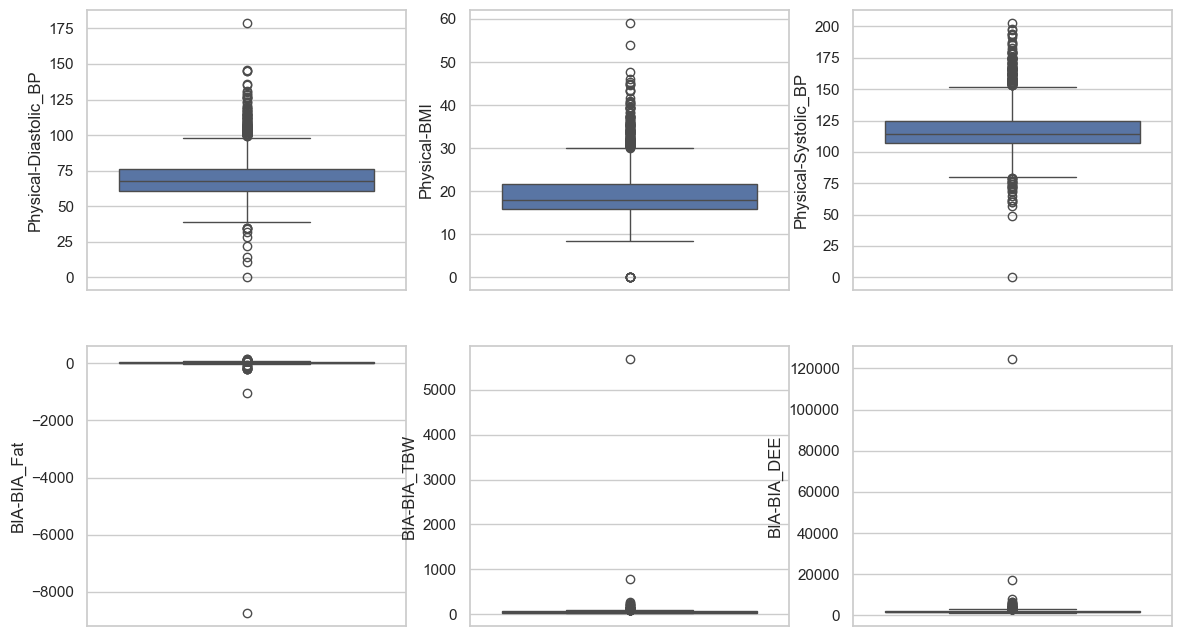

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))

sns.boxplot(y=df['Physical-Diastolic_BP'], ax=ax1)
sns.boxplot(y=df['Physical-BMI'], ax=ax2)
sns.boxplot(y=df['Physical-Systolic_BP'], ax=ax3)
sns.boxplot(y=df['BIA-BIA_Fat'], ax=ax4)
sns.boxplot(y=df['BIA-BIA_TBW'], ax=ax5)
sns.boxplot(y=df['BIA-BIA_DEE'], ax=ax6)

plt.show()

### Recommended Levels of Vitals 

The following are the minimum and maximum possible values of the vitals in humans, according to various sources.

1. Diastolic BP :
   A. Minimum : 60
   B. Maximum : 150

In [ ]:
diastole = len(df[(df['Physical-Diastolic_BP'] > 150) | (df['Physical-Diastolic_BP'] < 37)])
systole = len(df[df['Physical-Systolic_BP'] < 50])
bmi = len(df[(df['Physical-BMI'] == 0) | (df['Physical-BMI'] > 50)])
fat = len(df[df['BIA-BIA_Fat'] <= 0])
tbw = len(df[df['BIA-BIA_TBW'] > 500])
dee = len(df[df['BIA-BIA_DEE'] > 5000])

combined_count = len(df[
    ((df['Physical-Diastolic_BP'] > 150) | (df['Physical-Diastolic_BP'] < 37)) |
    (df['Physical-Systolic_BP'] < 50) |
    ((df['Physical-BMI'] == 0) | (df['Physical-BMI'] > 50)) |
    (df['BIA-BIA_Fat'] <= 0) |
    (df['BIA-BIA_TBW'] > 500) |
    (df['BIA-BIA_DEE'] > 5000)
])

print(diastole, systole, bmi, fat, tbw, dee, combined_count)

11 2 9 35 2 11 57


In [ ]:
df = df[~(
   ((df['Physical-Diastolic_BP'] > 150) | (df['Physical-Diastolic_BP'] < 37)) |
   (df['Physical-Systolic_BP'] < 50) |
   ((df['Physical-BMI'] == 0) | (df['Physical-BMI'] > 50)) |
   (df['BIA-BIA_Fat'] <= 0) |
   (df['BIA-BIA_TBW'] > 500) |
   (df['BIA-BIA_DEE'] > 5000)
)]

df.shape

(3903, 41)

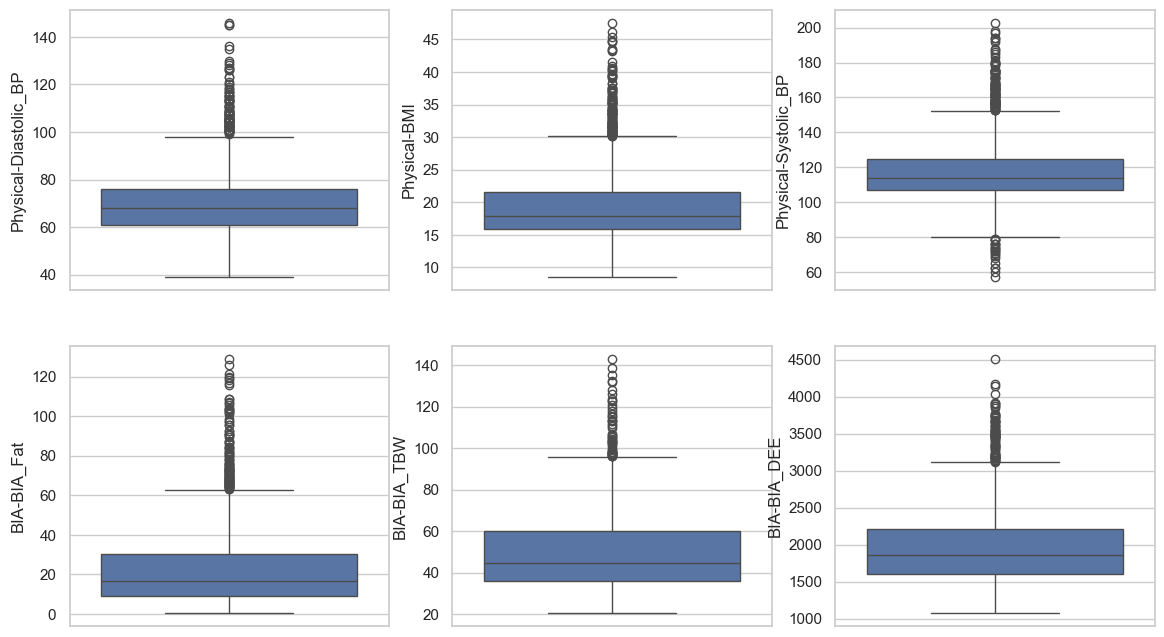

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))

sns.boxplot(y=df['Physical-Diastolic_BP'], ax=ax1)
sns.boxplot(y=df['Physical-BMI'], ax=ax2)
sns.boxplot(y=df['Physical-Systolic_BP'], ax=ax3)
sns.boxplot(y=df['BIA-BIA_Fat'], ax=ax4)
sns.boxplot(y=df['BIA-BIA_TBW'], ax=ax5)
sns.boxplot(y=df['BIA-BIA_DEE'], ax=ax6)

plt.show()

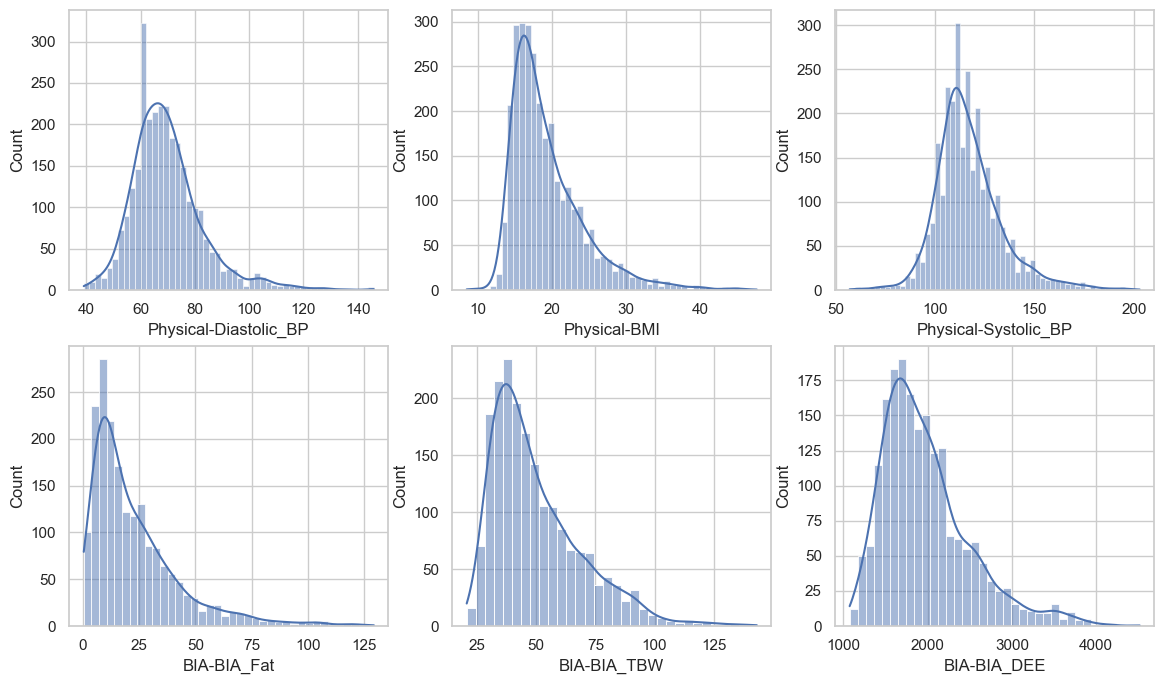

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))
sns.histplot(kde=True, x=df['Physical-Diastolic_BP'], ax=ax1)
sns.histplot(kde=True, x=df['Physical-BMI'], ax=ax2)
sns.histplot(kde=True, x=df['Physical-Systolic_BP'], ax=ax3)
sns.histplot(kde=True, x=df['BIA-BIA_Fat'], ax=ax4)
sns.histplot(kde=True, x=df['BIA-BIA_TBW'], ax=ax5)
sns.histplot(kde=True, x=df['BIA-BIA_DEE'], ax=ax6)
plt.show()

# Missing data and Data Imputation

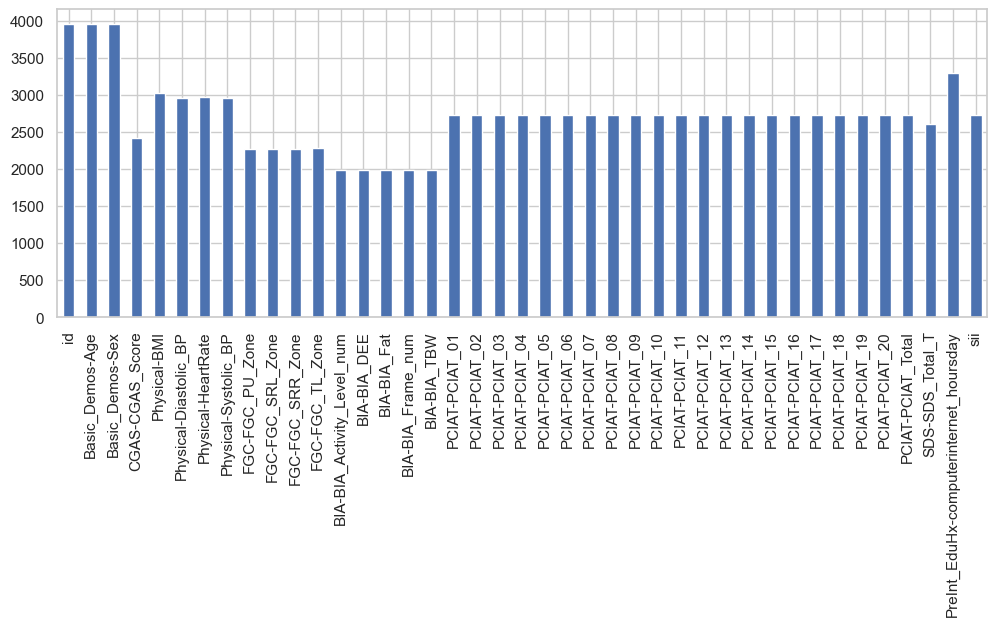

In [ ]:
counts = df.count()

plt.figure(figsize=(12,4))
counts.plot(kind='bar')
plt.show()

In [ ]:
def analyze_missingness(df, columns=None):
    """
    Analyze missing patterns for multiple columns
    
    Parameters:
    df: pandas DataFrame
    columns: list of columns to analyze. If None, analyzes all columns
    """
    # If no columns specified, analyze all columns
    if columns is None:
        columns = df.columns
    elif isinstance(columns, str):
        columns = [columns]
    
    # 1. Missing statistics for all specified columns
    missing_stats = df[columns].isnull().sum()
    missing_rate = (missing_stats / len(df) * 100).round(2)
    
    print("\nMissing Statistics:")
    for col, (count, rate) in zip(missing_stats.index, zip(missing_stats, missing_rate)):
        if count > 0:  # Only show columns with missing values
            print(f"{col}: {count} missing ({rate}%)")
    
    # 2. Correlation between missing patterns
    cols_with_missing = [col for col in columns if df[col].isnull().any()]
    if len(cols_with_missing) > 1:
        print("\nCorrelation between missing patterns:")
        missing_correlation = df[cols_with_missing].isnull().corr()
        # Show only correlations > 0.1
        for i in range(len(cols_with_missing)):
            for j in range(i+1, len(cols_with_missing)):
                corr = missing_correlation.iloc[i,j]
                if abs(corr) > 0.1:
                    print(f"{cols_with_missing[i]} - {cols_with_missing[j]}: {corr:.3f}")
    
    # 3. Test relationships with other variables
    print("\nSignificant relationships with other variables (p < 0.05):")

    num_rel_col = []
    cat_rel_col = []
    
    for col in cols_with_missing:
        missing_mask = df[col].isnull()
        if missing_mask.sum() == 0:
            continue
            
        print(f"\n{col}:")
        
        # Test against other numeric columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for num_col in numeric_cols:
            if num_col != col and df[num_col].nunique() > 1:
                complete = df[~missing_mask][num_col].dropna()
                missing = df[missing_mask][num_col].dropna()
                if len(complete) > 0 and len(missing) > 0:
                    try:
                        stat, pval = stats.ttest_ind(complete, missing)
                        if pval < 0.05:
                            num_rel_col.append(num_col)
                    except:
                        continue
        
        # Test against categorical columns
        cat_cols = df.select_dtypes(include=['object', 'category']).columns
        for cat_col in cat_cols:
            if cat_col != col and df[cat_col].nunique() > 1:
                contingency = pd.crosstab(missing_mask, df[cat_col])
                try:
                    stat, pval = stats.chi2_contingency(contingency)[:2]
                    if pval < 0.05:
                        cat_rel_col.append(cat_col)
                except:
                    continue

        print(f"Numerical columns : {num_rel_col}")
        print(f"Categorical columns : {cat_rel_col}")
    
    # 4. Visualize missing patterns
    plt.figure(figsize=(10, len(cols_with_missing)/2 + 1))
    sns.heatmap(df[cols_with_missing].isnull().T, 
                cmap='viridis',
                cbar=False,
                yticklabels=True)
    plt.title('Missing Data Patterns')
    plt.xlabel('Row Index')
    plt.ylabel('Columns')
    plt.show()
    
    # 5. Provide interpretation for each column
    print("\nInterpretation:")
    for col in cols_with_missing:
        print(f"\n{col}:")
        missing_mask = df[col].isnull()
        
        # Check for relationships with other variables
        has_relationships = False
        for other_col in df.columns:
            if other_col != col and df[other_col].nunique() > 1:
                if df[other_col].dtype in ['int64', 'float64']:
                    complete = df[~missing_mask][other_col].dropna()
                    missing = df[missing_mask][other_col].dropna()
                    if len(complete) > 0 and len(missing) > 0:
                        try:
                            _, pval = stats.ttest_ind(complete, missing)
                            if pval < 0.05:
                                has_relationships = True
                                break
                        except:
                            continue
        
        if not has_relationships:
            print("- Likely MCAR: No significant relationships found with other variables")
            print("- Recommendation: Simple imputation methods might be appropriate")
        else:
            print("- Likely MAR: Missing values are related to other variables")
            print("- Recommendation: Consider multiple imputation or advanced methods")


Missing Statistics:
CGAS-CGAS_Score: 1539 missing (38.86%)
BIA-BIA_Activity_Level_num: 1969 missing (49.72%)
FGC-FGC_PU_Zone: 1689 missing (42.65%)

Correlation between missing patterns:
CGAS-CGAS_Score - BIA-BIA_Activity_Level_num: 0.404
CGAS-CGAS_Score - FGC-FGC_PU_Zone: 0.226
BIA-BIA_Activity_Level_num - FGC-FGC_PU_Zone: 0.520

Significant relationships with other variables (p < 0.05):

CGAS-CGAS_Score:
Numerical columns : ['Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 'Physical-HeartRate', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'PreInt_EduHx-computerinternet_hoursday']
Categorical columns : []

BIA-BIA_Activity_Level_num:
Numerical columns : ['Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 'Physical-HeartRate', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'PreInt_EduHx-computerinternet_hoursday', 'CGAS-CGAS_Score', 'Physical-Diastolic_BP

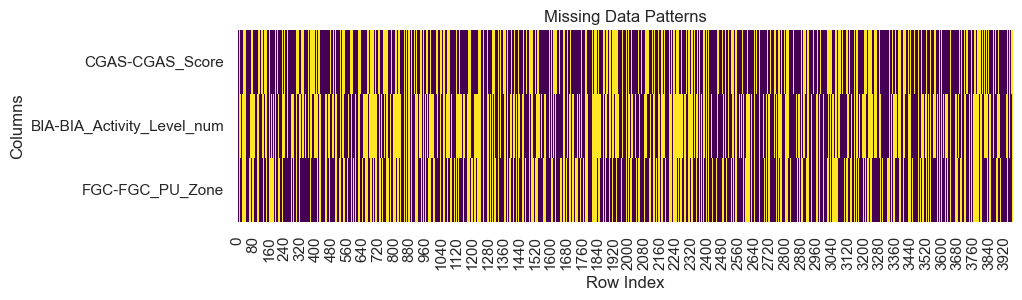


Interpretation:

CGAS-CGAS_Score:
- Likely MAR: Missing values are related to other variables
- Recommendation: Consider multiple imputation or advanced methods

BIA-BIA_Activity_Level_num:
- Likely MAR: Missing values are related to other variables
- Recommendation: Consider multiple imputation or advanced methods

FGC-FGC_PU_Zone:
- Likely MAR: Missing values are related to other variables
- Recommendation: Consider multiple imputation or advanced methods


In [ ]:
analyze_missingness(df, ['CGAS-CGAS_Score', 'BIA-BIA_Activity_Level_num', 'FGC-FGC_PU_Zone'])